# 解码器设计

1.  **数据生成**：创建多组随机的输入序列（0-20ns）和对应的STO响应。
2.  **储备池状态提取**：对于每个响应，我们在20ns之后进行采样，形成“储备池状态向量” `X`。
3.  **目标向量定义**：原始的输入序列作为我们的“目标向量” `Y_train`。
4.  **解码器模型**：建立一个线性解码器 `Y_out = W * X + b`。
5.  **训练**：使用随机梯度下降（SGD）来优化权重 `W` 和偏置 `b`，以最小化预测 `Y_out` 和目标 `Y_train` 之间的均方误差（MSE）。
6.  **评估**：使用训练好的解码器来预测一个从未见过的新输入序列。



# Python 代码实现

In [18]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm # 用于显示进度条
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

## 1. LLG 求解器


In [19]:
# 物理参数
alpha = 0.02
gamma = 1.7e7 / 1e9
H_ext = 200.0
H_deg = 8400.0
omega_ac_GHz = 32.0
omega_ac = omega_ac_GHz * 2 * np.pi
a_ac = 26.0
e_x = np.array([1.0, 0.0, 0.0])
e_z = np.array([0.0, 0.0, 1.0])

def llg_solver(input_sequence, m0, t_duration=40, t_points=1000):
    """
    接收一个二进制输入序列和初始磁化状态 m0，运行LLG模拟。
    input_sequence: e.g., [1, 0] for the first 20ns.
    m0: 初始磁化矢量, e.g., [0.1, 0.9, -0.42]
    """
    input_width = 10 # 每个输入持续10ns
  
    def get_aj(t):
        idx = int(t // input_width)
        if idx >= len(input_sequence):
            idx = len(input_sequence) - 1
        a_dc = 100.0 if input_sequence[idx] == 0 else 200.0
        return a_dc + a_ac * np.cos(omega_ac * t)

    def llg_equation(t, m):
        m = m / np.linalg.norm(m)
        H_eff = H_ext * e_x - H_deg * m[2] * e_z
        a_j_t = get_aj(t)
        T_field = -gamma * np.cross(m, H_eff)
        T_stt = gamma * a_j_t * np.cross(m, np.cross(m, e_x))
        T_total = T_field + T_stt
        dmdt = (1 / (1 + alpha**2)) * (T_total + alpha * np.cross(m, T_total))
        return dmdt

    t_span = [0, t_duration]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
  
    sol = solve_ivp(
        llg_equation, t_span, m0, method='LSODA', t_eval=t_eval
    )
    return sol.t, sol.y[2]


## 2. 数据生成与状态提取 


In [ ]:
def generate_dataset(num_samples, input_len=2):
    """
    生成用于训练的数据集，每次都使用随机的初始状态 m0。
    """
    dataset = []
    print(f"正在生成 {num_samples} 组训练数据 (使用随机初始状态)...")
    for _ in tqdm(range(num_samples)):
        # 随机生成 0-20ns 的输入序列
        target_inputs = np.random.randint(0, 2, size=input_len)
      
        # 生成一个随机的单位矢量作为初始状态 m0
        m0_rand = np.random.randn(3)
        m0_rand = m0_rand / np.linalg.norm(m0_rand)
      
        # 运行模拟
        t, mz = llg_solver(target_inputs, m0_rand, t_duration=30, t_points=301)
      
        # 提取储备池状态：对 20ns 到 30ns 的 mz 进行采样
        start_time_idx = np.where(t >= 20)[0][0]
        end_time_idx = np.where(t >= 30)[0][0]
        reservoir_states = mz[start_time_idx:end_time_idx+1:20]
      
        dataset.append((reservoir_states, target_inputs))
      
    return dataset

## 3. 线性解码器和训练

In [21]:
class LinearDecoder:
    def __init__(self, input_size, output_size):
        # 初始化权重和偏置
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.bias = np.zeros(output_size)
      
    def predict(self, x):
        # 预测: Y = W * X + b
        return np.dot(self.weights, x) + self.bias

    def train_sgd(self, dataset, learning_rate=0.001, epochs=50):
        """使用随机梯度下降法进行训练"""
        loss_history = []
        for epoch in range(epochs):
            total_loss = 0
            # 每次迭代前都打乱数据顺序
            np.random.shuffle(dataset)
          
            for x, y_true in dataset:
                # 前向传播
                y_pred = self.predict(x)
              
                # 计算误差
                error = y_pred - y_true
              
                # 计算损失 (MSE)
                loss = np.mean(error**2)
                total_loss += loss
              
                # 计算梯度
                grad_weights = 2 * np.outer(error, x)
                grad_bias = 2 * error
              
                # 更新权重和偏置 (SGD步骤)
                self.weights -= learning_rate * grad_weights
                self.bias -= learning_rate * grad_bias
              
            avg_loss = total_loss / len(dataset)
            loss_history.append(avg_loss)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
        return loss_history

## 4.主程序：生成数据、训练和评估

正在生成 1000 组训练数据 (使用随机初始状态)...


100%|██████████| 1000/1000 [10:32<00:00,  1.58it/s]



开始训练解码器...
Epoch [10/150], Loss: 0.249893
Epoch [20/150], Loss: 0.249173
Epoch [30/150], Loss: 0.248409
Epoch [40/150], Loss: 0.248775
Epoch [50/150], Loss: 0.248692
Epoch [60/150], Loss: 0.248497
Epoch [70/150], Loss: 0.248285
Epoch [80/150], Loss: 0.248492
Epoch [90/150], Loss: 0.248401
Epoch [100/150], Loss: 0.248463
Epoch [110/150], Loss: 0.248273
Epoch [120/150], Loss: 0.248198
Epoch [130/150], Loss: 0.248292
Epoch [140/150], Loss: 0.248128
Epoch [150/150], Loss: 0.248253


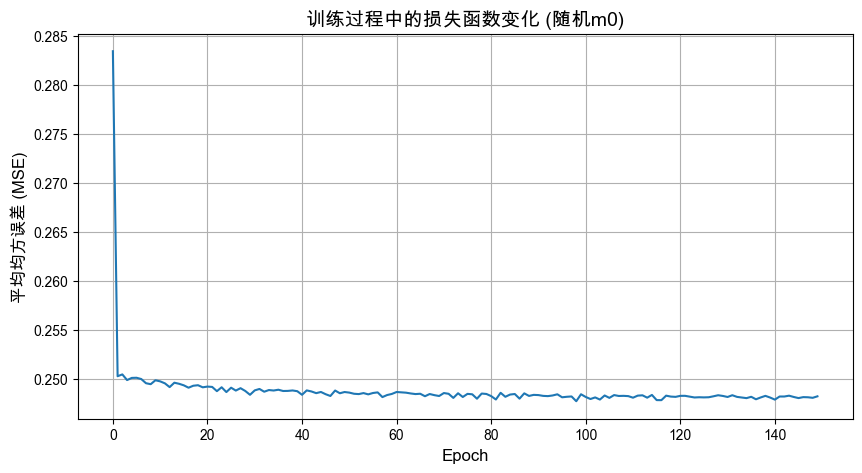

In [ ]:
# 生成数据集
num_train_samples = 1000 # 增加样本量以应对更复杂的数据分布
input_length = 2
dataset = generate_dataset(num_train_samples, input_len=input_length)


开始训练解码器...
Epoch [10/300], Loss: 0.249552
Epoch [20/300], Loss: 0.249325
Epoch [30/300], Loss: 0.248901
Epoch [40/300], Loss: 0.248424
Epoch [50/300], Loss: 0.248706
Epoch [60/300], Loss: 0.248193
Epoch [70/300], Loss: 0.248127
Epoch [80/300], Loss: 0.248329
Epoch [90/300], Loss: 0.248297
Epoch [100/300], Loss: 0.248277
Epoch [110/300], Loss: 0.248279
Epoch [120/300], Loss: 0.248103
Epoch [130/300], Loss: 0.248113
Epoch [140/300], Loss: 0.248219
Epoch [150/300], Loss: 0.247964
Epoch [160/300], Loss: 0.248177
Epoch [170/300], Loss: 0.248056
Epoch [180/300], Loss: 0.247988
Epoch [190/300], Loss: 0.248062
Epoch [200/300], Loss: 0.248013
Epoch [210/300], Loss: 0.248204
Epoch [220/300], Loss: 0.248022
Epoch [230/300], Loss: 0.248241
Epoch [240/300], Loss: 0.248206
Epoch [250/300], Loss: 0.248096
Epoch [260/300], Loss: 0.248043
Epoch [270/300], Loss: 0.247706
Epoch [280/300], Loss: 0.248178
Epoch [290/300], Loss: 0.248031
Epoch [300/300], Loss: 0.247992


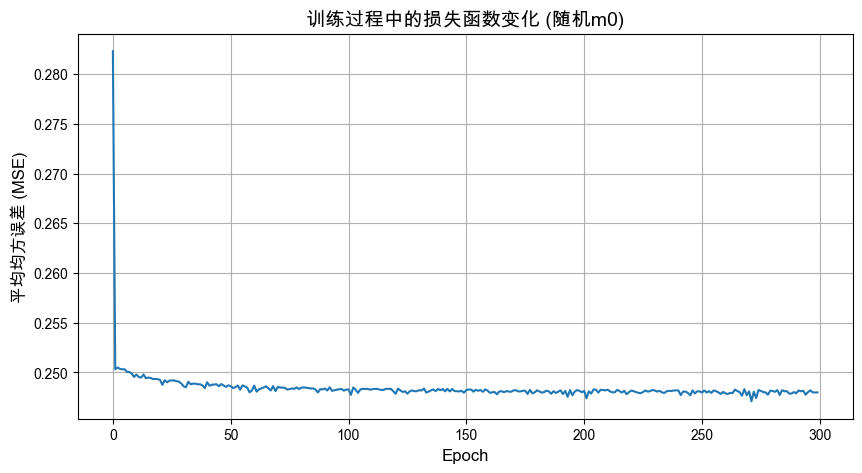

In [31]:
# 初始化解码器
reservoir_size = dataset[0][0].shape[0]
output_size = input_length
decoder = LinearDecoder(input_size=reservoir_size, output_size=output_size)

# 训练解码器
print("\n开始训练解码器...")
# 可能需要调整学习率和epochs以获得更好的收敛
loss_hist = decoder.train_sgd(dataset, learning_rate=0.002, epochs=300)

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(loss_hist)
plt.title('训练过程中的损失函数变化 (随机m0)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('平均均方误差 (MSE)', fontsize=12)
plt.grid(True)
plt.show()

## 5. 评估解码器性能 (使用多个随机样本)


开始评估解码器...
--- 测试样本 1/10 ---
真实输入 (0-20ns): [1 0]
初始状态 m0: [-0.03, -0.98, -0.21]
解码器预测值: [1 0]
结果: 解码成功！

--- 测试样本 2/10 ---
真实输入 (0-20ns): [0 0]
初始状态 m0: [-0.47, -0.86, 0.21]
解码器预测值: [0 0]
结果: 解码成功！

--- 测试样本 3/10 ---
真实输入 (0-20ns): [0 0]
初始状态 m0: [0.48, -0.66, 0.58]
解码器预测值: [1 0]
结果: 解码失败。

--- 测试样本 4/10 ---
真实输入 (0-20ns): [1 1]
初始状态 m0: [0.73, -0.11, 0.67]
解码器预测值: [1 1]
结果: 解码成功！

--- 测试样本 5/10 ---
真实输入 (0-20ns): [1 1]
初始状态 m0: [-0.83, -0.31, 0.47]
解码器预测值: [1 1]
结果: 解码成功！

--- 测试样本 6/10 ---
真实输入 (0-20ns): [0 1]
初始状态 m0: [0.38, 0.45, -0.81]
解码器预测值: [0 1]
结果: 解码成功！

--- 测试样本 7/10 ---
真实输入 (0-20ns): [0 1]
初始状态 m0: [0.50, -0.70, -0.50]
解码器预测值: [0 0]
结果: 解码失败。

--- 测试样本 8/10 ---
真实输入 (0-20ns): [0 0]
初始状态 m0: [0.51, 0.48, 0.71]
解码器预测值: [0 0]
结果: 解码成功！

--- 测试样本 9/10 ---
真实输入 (0-20ns): [1 0]
初始状态 m0: [-0.43, 0.72, 0.54]
解码器预测值: [0 1]
结果: 解码失败。

--- 测试样本 10/10 ---
真实输入 (0-20ns): [0 0]
初始状态 m0: [0.77, 0.50, -0.40]
解码器预测值: [0 1]
结果: 解码失败。

解码器在 10 个随机测试样本上的准确率: 60.00%


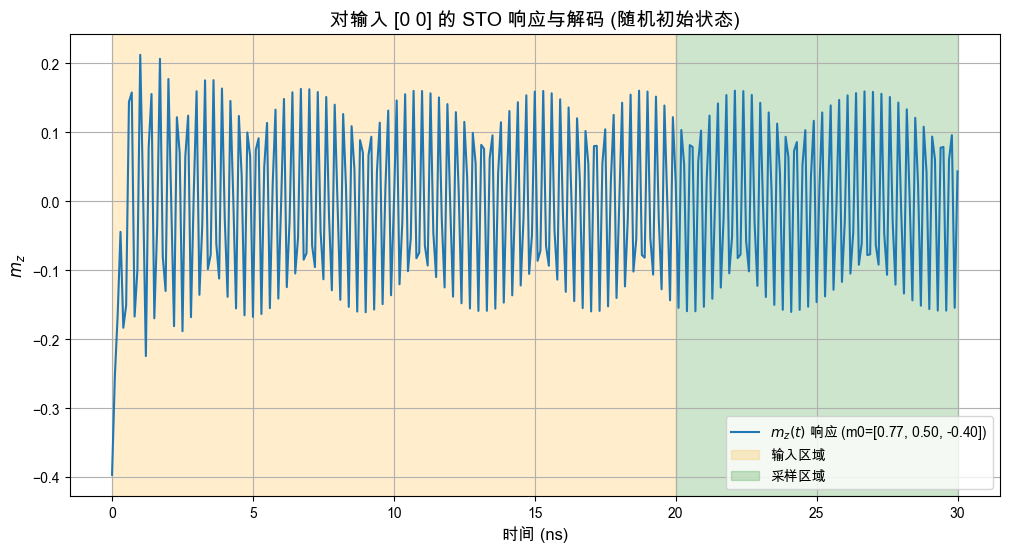

In [32]:
print("\n开始评估解码器...")
num_test_samples = 10
correct_predictions = 0

for i in range(num_test_samples):
    print(f"--- 测试样本 {i+1}/{num_test_samples} ---")
    # 生成一个全新的测试样本，同样使用随机 m0
    test_input = np.random.randint(0, 2, size=input_length)
    m0_test = np.random.randn(3)
    m0_test = m0_test / np.linalg.norm(m0_test)
  
    print(f"真实输入 (0-20ns): {test_input}")
    print(f"初始状态 m0: [{m0_test[0]:.2f}, {m0_test[1]:.2f}, {m0_test[2]:.2f}]")

    # 运行模拟
    t_test, mz_test = llg_solver(test_input, m0_test, t_duration=30, t_points=301)

    # 提取测试用的储备池状态
    start_idx = np.where(t_test >= 20)[0][0]
    end_idx = np.where(t_test >= 30)[0][0]
    x_test = mz_test[start_idx:end_idx+1:10]

    # 预测
    predicted_output_continuous = decoder.predict(x_test)
    predicted_output_binary = (predicted_output_continuous > 0.5).astype(int)

    print(f"解码器预测值: {predicted_output_binary}")

    if np.array_equal(test_input, predicted_output_binary):
        print("结果: 解码成功！\n")
        correct_predictions += 1
    else:
        print("结果: 解码失败。\n")

accuracy = (correct_predictions / num_test_samples) * 100
print(f"解码器在 {num_test_samples} 个随机测试样本上的准确率: {accuracy:.2f}%")

# 可视化最后一个测试样本的过程
plt.figure(figsize=(12, 6))
plt.plot(t_test, mz_test, label=f'$m_z(t)$ 响应 (m0=[{m0_test[0]:.2f}, {m0_test[1]:.2f}, {m0_test[2]:.2f}])')
plt.axvspan(0, 20, color='orange', alpha=0.2, label='输入区域')
plt.axvspan(20, 30, color='green', alpha=0.2, label='采样区域')
plt.title(f'对输入 {test_input} 的 STO 响应与解码 (随机初始状态)', fontsize=14)
plt.xlabel('时间 (ns)', fontsize=12)
plt.ylabel('$m_z$', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


### 代码解释

1.  **`llg_solver` 函数**：我们对之前的求解器做了微小调整，使其能够接收一个二进制序列作为输入，并自动映射为 \(a_{dc}\) 值。它返回模拟的时间和 \(m_z\) 演化曲线。
2.  **`generate_dataset` 函数**：这是数据准备步骤。它循环多次，每次都生成一个随机的二进制输入序列（例如 `[1, 0]`），然后调用 `llg_solver` 得到 \(m_z\) 响应。关键在于，它只截取并采样 **20ns之后** 的 \(m_z\) 值作为特征向量 `reservoir_states`。这个向量和原始的输入序列 `target_inputs` 构成了一对训练样本 `(X, Y)`。
3.  **`LinearDecoder` 类**：
    *   `__init__`：根据储备池状态的维度（输入大小）和目标序列的长度（输出大小）来初始化权重 `W` 和偏置 `b`。
    *   `predict`：执行简单的线性变换 `W*X + b`。
    *   `train_sgd`：实现了完整的随机梯度下降训练流程。它迭代（epochs）地处理整个数据集，对每个样本计算预测、误差和梯度，并据此更新权重。我们将损失函数的变化记录下来以便后续可视化。
4.  **主程序**：
    *   首先调用 `generate_dataset` 创建一个包含500个样本的训练集。
    *   然后初始化 `LinearDecoder` 并调用 `train_sgd` 方法进行训练。
    *   训练完成后，我们生成一个**全新的、从未见过的**随机输入 `test_input`。
    *   我们模拟它对应的STO响应，提取其储备池状态 `x_test`。
    *   最后，用训练好的解码器对 `x_test` 进行预测，并将结果与真实的 `test_input` 进行比较，以验证解码器的性能。

这个例子完美地展示了储备池计算的威力：我们完全没有改变 STO 的物理参数或其动力学方程（即“储备池”是固定的），仅仅通过训练一个简单的线性读出层，就能够从系统未来的状态中“解码”出过去的信息。这证明了 STO 的非线性动力学确实将输入历史有效地编码到了其状态之中。